In [43]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

import rdkit
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs



#randomforestclassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from mordred import Calculator, descriptors

#PCA
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#compute accuracy
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef

In [44]:
df_tested_molecules1 = pd.read_csv('tested_molecules-1.csv')
df_tested_molecules2 = pd.read_csv('tested_molecules_v2.csv')

df = pd.concat([df_tested_molecules1, df_tested_molecules2], ignore_index=True)
df_molecules = df.copy(deep=True)
smiles_good_inhibitor = df[df['ALDH1_inhibition'] == 1].reset_index()
smiles_bad_inhibitor = df[df['ALDH1_inhibition'] == 0].reset_index()
PandasTools.AddMoleculeColumnToFrame(df_molecules, smilesCol='SMILES')
df_molecules.shape

(2000, 3)

In [45]:
def plot_mol (smiles_df, molecule_index):
    smiles = smiles_df['SMILES'][molecule_index]
    mol =Chem.MolFromSmiles(smiles)
    Draw.MolToMPL(mol, size=(200, 200))


In [46]:
def plot_list_mol(smiles_df):
    mol_list = []
    for smiles in smiles_df:
        for smiles in smiles_df['SMILES']:    # assuming your column is called Smiles
            mol = Chem.MolFromSmiles(smiles)
            Chem.SanitizeMol(mol,sanitizeOps=Chem.SANITIZE_SYMMRINGS|Chem.SANITIZE_SETCONJUGATION|Chem.SANITIZE_SETHYBRIDIZATION)
            mol.Compute2DCoords()
            mol_list.append(mol)
            Draw.MolToMPL(mol, size=(200, 200))

In [47]:
def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [48]:
#split fingerprint data set in training and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(df_molecules, df_molecules['ALDH1_inhibition'], stratify=df_molecules['ALDH1_inhibition'],test_size=0.25, random_state=seed)

In [49]:
X_train_fp = rdkit_numpy_convert([AllChem.GetMorganFingerprintAsBitVect(x,3) for x in X_train['ROMol']])
X_test_fp = rdkit_numpy_convert([AllChem.GetMorganFingerprintAsBitVect(x,3) for x in X_test['ROMol']])
y_train_fp = y_train
y_test_fp = y_test 

In [50]:
#create 10 folds
cv = StratifiedKFold(n_splits=5)

In [51]:
# create grid search dictionary
param_grid = {"max_features": [X_train_fp.shape[1] // 10, X_train_fp.shape[1] // 7, X_train_fp.shape[1] // 5, X_train_fp.shape[1] // 3], 
              "n_estimators": [100, 250, 500]}

In [52]:
m = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)


In [53]:
m.fit(X_train_fp, y_train_fp)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': [204, 292, 409, 682],
                         'n_estimators': [100, 250, 500]},
             verbose=1)

In [54]:
m.cv_results_['mean_test_score']

array([0.78866667, 0.792     , 0.798     , 0.79      , 0.79866667,
       0.794     , 0.78733333, 0.79      , 0.78733333, 0.79333333,
       0.784     , 0.79      ])

In [55]:

m.cv_results_['params']

[{'max_features': 204, 'n_estimators': 100},
 {'max_features': 204, 'n_estimators': 250},
 {'max_features': 204, 'n_estimators': 500},
 {'max_features': 292, 'n_estimators': 100},
 {'max_features': 292, 'n_estimators': 250},
 {'max_features': 292, 'n_estimators': 500},
 {'max_features': 409, 'n_estimators': 100},
 {'max_features': 409, 'n_estimators': 250},
 {'max_features': 409, 'n_estimators': 500},
 {'max_features': 682, 'n_estimators': 100},
 {'max_features': 682, 'n_estimators': 250},
 {'max_features': 682, 'n_estimators': 500}]

## Mordred descriptors model

In [56]:
#Split data into Test data set and training data set before doing anything.
mordred_calc = Calculator(descriptors, ignore_3D=True)

X_train_mor =  mordred_calc.pandas(mol for mol in X_train['ROMol'])
X_train_mor = X_train_mor.select_dtypes(include=['float64', 'int64', 'float'])

X_test_mor = mordred_calc.pandas(mol for mol in X_test['ROMol'])
X_test_mor = X_train_mor.select_dtypes(include=['float64', 'int64', 'float'])

y_train_mor = y_train
y_test_mor = y_test

In [57]:
# Create correlation matrix
corr_matrix = X_train_mor.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_train_mor.drop(to_drop, axis=1, inplace=True)
X_test_mor.drop(to_drop, axis=1, inplace=True)
X_train_mor.shape

(1500, 606)

c:\Users\20212497\.conda\envs\enviroment2\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


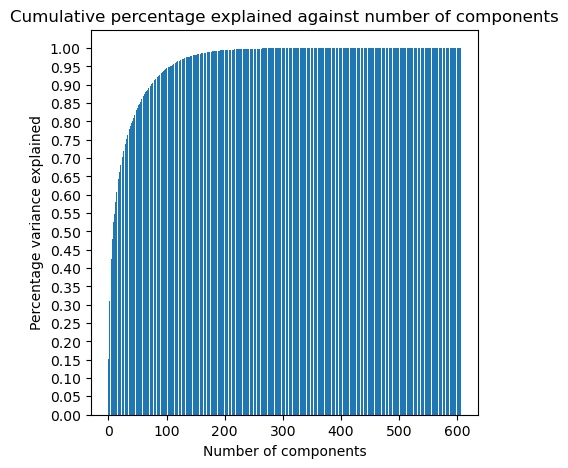

In [59]:
#perform PCA on training features as feature selection

scaler = StandardScaler()
matrix_mordred_scaled = scaler.fit_transform(X_train_mor)
df_train_mordred_pca = pd.DataFrame(matrix_mordred_scaled, columns=X_train_mor.columns)

covariance_matrix =df_train_mordred_pca.cov().to_numpy()
w,v = LA.eig(covariance_matrix)
#print(w[0]/sum(w))
explained = np.cumsum(w/sum(w))
#print(explained)
amount_variables = [*range(len(explained))]

fig = plt.figure(figsize =(5, 5))
plt.bar(amount_variables, explained)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylabel('Percentage variance explained')
plt.xlabel('Number of components')
plt.title('Cumulative percentage explained against number of components')
plt.show()


In [71]:
loadings = v * np.sqrt(w)
# Get the absolute mean loadings for each variable
abs_mean_loadings = np.abs(loadings).mean(axis=0)

# Create a dictionary to store the variable names and their corresponding absolute mean loadings
variable_loadings = {var: abs_mean_loadings[i] for i, var in enumerate(X_train_mor.columns)}

# Sort the variable_loadings dictionary by the absolute mean loadings in descending order
sorted_loadings = sorted(variable_loadings.items(), key=lambda x: x[1], reverse=True)

# Extract the top 100 variables based on their loadings
top_100_variables = [var[0] for var in sorted_loadings[:100]]

# Print the ranked variables with their loadings
print("Top 100 Variables Ranked by Loadings:")
for i, var in enumerate(top_100_variables):
    loading = variable_loadings[var]
    print(f"{i+1}. {var}: {loading}")

Top 100 Variables Ranked by Loadings:
1. nAcid: 0.23859785154092353
2. nBase: 0.16902339279621512
3. SpAbs_A: 0.15284894453983774
4. SpMax_A: 0.1241706504240246
5. SpDiam_A: 0.12401449116227588
6. SpMAD_A: 0.10880328926433341
7. VR1_A: 0.09974448148883121
8. VE1_A: 0.09922599753454543
9. nAtom: 0.08771265374280562
10. nSpiro: 0.0854390037969065
11. nAromAtom: 0.08196506267267481
12. nBridgehead: 0.0806918581953526
13. nHetero: 0.07532788239562035
14. nB: 0.07259218665152022
15. nH: 0.07028860639443975
16. nC: 0.0691158036510845
17. nS: 0.0588502835569189
18. nO: 0.05876771543650452
19. nF: 0.05714169839962195
20. nN: 0.056872243323155554
21. nCl: 0.05557699532068605
22. nX: 0.05358379175363663
23. nP: 0.05193198845792226
24. nI: 0.051307532645349735
25. ATS3dv: 0.048853876087963446
26. ATS1dv: 0.04882796347317752
27. ATS6dv: 0.04762433435814379
28. ATS0dv: 0.046418227550324404
29. nBr: 0.04608096149829327
30. ATS7dv: 0.04476689684544268
31. ATS8dv: 0.04439898341824744
32. ATS5dv: 0.042

In [61]:
#PCA on mordred
pca = decomposition.PCA(n_components=100)
PCA_mordred_features = pca.fit_transform(df_train_mordred_pca)
pca_mordred_df = pd.DataFrame(data=PCA_mordred_features, columns=[ 'PC'+str(x) for x in range(100)])
pca_mordred_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99
0,0.633542,17.919920,1.347384,-3.386596,-2.775243,7.715497,0.464556,-0.276343,-1.938721,-0.500771,...,0.136281,-1.240992,0.241879,0.568538,-0.027782,-0.731151,-0.192236,-0.382272,-0.662827,-0.287516
1,-4.461686,-4.100818,-4.150625,1.478995,-5.477337,5.612818,-2.860200,3.041699,3.152402,-3.063176,...,0.080584,0.857880,1.208658,-0.371439,0.092785,0.308135,0.498567,0.167962,0.913124,0.239943
2,-13.684132,3.693289,-1.101350,-5.738936,3.371777,0.038673,-4.537659,-5.766432,-2.037707,-2.226832,...,-2.029517,0.178565,-1.123038,0.436584,-0.308301,2.101269,0.562058,0.765655,0.872771,-0.223067
3,9.358450,-7.540071,-3.548709,-1.507019,4.981961,0.576373,6.205876,3.039906,1.518371,0.954328,...,0.366613,0.068844,-0.476973,-0.909198,-0.018409,-0.705128,0.752464,-1.546373,0.121391,-0.218960
4,7.742822,-8.345265,-1.074736,-4.414908,0.708139,-2.688584,5.821589,0.555514,0.093833,1.511341,...,0.165134,0.322406,-0.740845,0.235775,-0.017058,-0.137307,-0.119788,-0.053281,0.445679,-0.383892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-21.145967,5.786537,26.609680,6.312786,-13.748303,1.832680,14.911129,3.945807,-5.706137,5.310151,...,0.745452,-1.530990,-5.699440,2.532271,-1.649849,3.226807,-2.337807,0.147568,-1.942985,-2.559826
1496,-9.031807,2.678430,-0.624763,1.428246,-2.551770,1.192309,-5.519885,-0.975160,-1.342874,-0.125176,...,-1.125269,-0.828867,0.030911,-0.220673,0.231428,-0.057340,0.040329,-0.256483,-0.086612,-0.492470
1497,8.362447,2.638183,-1.769212,-3.398216,-5.442211,-2.252620,-1.331654,1.133638,1.245729,6.054875,...,-0.356696,0.100420,1.092950,0.290192,0.316202,0.046899,1.198724,0.222668,0.533129,-0.084798
1498,4.396619,-3.218267,-3.090548,-2.403945,-5.713228,-5.329693,0.761253,0.924499,-0.590192,0.954620,...,0.684828,0.112300,-1.031376,2.526093,-0.900291,-1.385248,-0.263627,0.192542,-0.172940,0.969192


In [69]:
top_components = 100  # Define the number of top components

# Retrieve the loadings from PCA
loadings = pca.components_[:top_components, :]

# Create a DataFrame to store the loadings
loadings_df = pd.DataFrame(data=loadings, columns=df_train_mordred_pca.columns)

# Print the top 100 loadings
for i in range(top_components):
    print(f"Loadings for Component {i+1}:")
    top_loadings = loadings_df.iloc[i].nlargest(100)  # Retrieve the top 100 loadings for each component
    print(top_loadings)


Loadings for Component 1:
ATSC0dv        0.111094
ATSC0d         0.110634
mZagreb1       0.109961
ATS4s          0.109558
ATS5s          0.108255
                 ...   
VSA_EState1    0.058858
BCUTdv-1h      0.057728
PEOE_VSA2      0.057680
ATSC2v         0.057227
nAHRing        0.056589
Name: 0, Length: 100, dtype: float64
Loadings for Component 2:
AATS0se           0.140652
AATS1se           0.132493
AATS2s            0.130624
ETA_epsilon_2     0.129700
AATS0dv           0.127300
                    ...   
NaaN              0.035249
AXp-2d            0.034004
ETA_dEpsilon_D    0.033869
JGI7              0.033663
Xc-3d             0.033333
Name: 1, Length: 100, dtype: float64
Loadings for Component 3:
HybRatio      0.126450
BalabanJ      0.121505
GATS1d        0.119648
AETA_eta_L    0.116415
AXp-0dv       0.111256
                ...   
AATS2Z        0.025012
C2SP1         0.024830
NssNH2        0.024315
GATS2dv       0.024065
AATSC2s       0.024019
Name: 2, Length: 100, dtype: float

Text(0.5, 1.0, 'Scoreplot of PC1 and PC2 grouped by Activity')

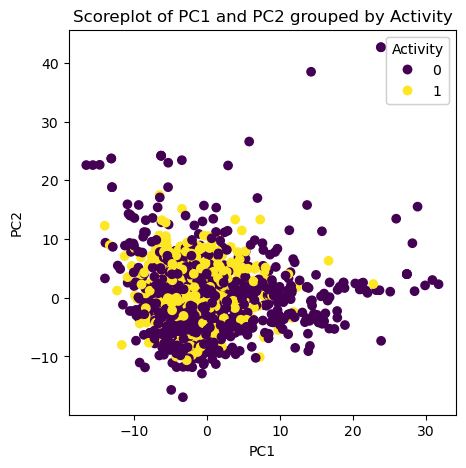

In [63]:
fig, ax1 = plt.subplots(figsize=(5,5))

#plot PC1 against PC2 in a scatter matrix and group colours by activity.
scatter = ax1.scatter(pca_mordred_df['PC1'], pca_mordred_df['PC2'], c= y_train_mor, cmap='viridis')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

legend1 = ax1.legend(*scatter.legend_elements(),
                    loc="upper right", title="Activity")
ax1.add_artist(legend1)
ax1.set_title('Scoreplot of PC1 and PC2 grouped by Activity')

In [64]:
#create 10 folds
cv = StratifiedKFold(n_splits=5)

In [65]:
# create grid search dictionary
param_grid = {"max_features": [pca_mordred_df.shape[1] // 10, pca_mordred_df.shape[1] // 7, pca_mordred_df.shape[1] // 5, pca_mordred_df.shape[1] // 3], 
              "n_estimators": [100, 250, 500]}

In [66]:
m_mordred = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)

In [67]:
# run model building
m_mordred.fit(pca_mordred_df, y_train_mor)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': [10, 14, 20, 33],
                         'n_estimators': [100, 250, 500]},
             verbose=1)

In [ ]:
m_mordred.cv_results_['mean_test_score']

array([0.768     , 0.75533333, 0.76466667, 0.75133333, 0.762     ,
       0.76466667, 0.76      , 0.774     , 0.762     , 0.77333333,
       0.75733333, 0.768     ])

In [ ]:
m_mordred.cv_results_['params']

[{'max_features': 10, 'n_estimators': 100},
 {'max_features': 10, 'n_estimators': 250},
 {'max_features': 10, 'n_estimators': 500},
 {'max_features': 14, 'n_estimators': 100},
 {'max_features': 14, 'n_estimators': 250},
 {'max_features': 14, 'n_estimators': 500},
 {'max_features': 20, 'n_estimators': 100},
 {'max_features': 20, 'n_estimators': 250},
 {'max_features': 20, 'n_estimators': 500},
 {'max_features': 33, 'n_estimators': 100},
 {'max_features': 33, 'n_estimators': 250},
 {'max_features': 33, 'n_estimators': 500}]

In [ ]:
#scale test data
X_test_mor_scaled = scaler.transform(X_test_mor)
X_test_PCA = pca.transform(X_test_mor_scaled)
df_X_test_PCA = pd.DataFrame(data=X_test_PCA, columns=[ 'PC'+str(x) for x in range(100)])

C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [ ]:
#let model predict
pred_mordred = m_mordred.predict(X_test_PCA)

C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,not inhibitor,inhibitor
7,0.176,0.824
382,0.248,0.752
38,0.284,0.716
10,0.284,0.716
151,0.284,0.716
...,...,...
226,0.992,0.008
70,0.996,0.004
422,0.996,0.004
222,0.996,0.004


In [ ]:
accuracy_score(y_test_mor, pred_mordred)

0.798

In [ ]:
matthews_corrcoef(y_test_mor, pred_mordred)

0.487538090401277

In [ ]:
cohen_kappa_score(y_test_mor, pred_mordred)

0.47395833333333337

In [ ]:
pred_prob_mordred = m_mordred.predict_proba(X_test_PCA)

df_pred_prob_mordred = pd.DataFrame(data=pred_prob_mordred, columns=['not inhibitor', 'inhibitor'])
df_pred_prob_mordred.sort_values(by='inhibitor', ascending=False)
X_test_mor

C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nAtom,...,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,SRW05,TSRW10,mZagreb1
334,0,0,38.848165,2.462647,4.925293,1.387434,4.668595,246.832390,12,54,...,0.012680,0.005324,0.003773,0.003798,0.002968,0.271124,0.833333,0.000000,63.637675,5.888889
1235,0,1,23.878321,2.384390,4.603150,1.326573,3.531252,173.924144,15,30,...,0.014762,0.014625,0.003948,0.010666,0.009437,0.379657,0.833333,2.397895,64.824124,4.555556
398,0,0,25.436017,2.261523,4.494136,1.271801,3.808341,139.799520,11,33,...,0.018561,0.010589,0.008568,0.009176,0.004362,0.416512,0.857143,2.397895,66.132838,6.555556
98,0,0,30.997613,2.457515,4.747138,1.347722,3.942599,223.085314,15,40,...,0.015802,0.010180,0.007307,0.007865,0.005332,0.348159,0.833333,3.044522,73.487639,5.527778
541,0,0,18.475475,2.249391,4.498782,1.231698,3.412412,84.698255,6,31,...,0.024671,0.015129,0.013958,0.005000,0.008264,0.423655,0.833333,0.000000,45.652835,5.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,18.626607,2.690274,5.128557,1.095683,3.456393,135.511655,0,46,...,0.021882,0.000000,0.000000,0.000000,0.000000,0.818964,0.750000,2.397895,66.790072,10.111111
1579,0,0,20.666207,2.269917,4.539834,1.291638,3.812985,72.218215,12,27,...,0.009419,0.011521,0.018105,0.007500,0.012346,0.416600,1.000000,0.000000,47.815263,4.944444
1870,0,0,32.128166,2.386712,4.773423,1.285127,4.294911,247.807255,12,47,...,0.019410,0.016493,0.010821,0.009805,0.004129,0.431219,1.000000,0.000000,59.568973,8.138889
497,0,1,35.646291,2.372061,4.744123,1.273082,4.403265,453.936828,12,50,...,0.015090,0.013123,0.007818,0.006900,0.005974,0.400478,1.000000,0.000000,62.903780,8.888889
